In [77]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [78]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [79]:
import seaborn as sns

In [80]:
sns.set_context('paper', font_scale=2.2)
sns.set_style('ticks')

In [81]:
import LB_colony_growth.LB_colony_growth as lb

import skimage as ski
import skimage.draw

In [88]:
dimension = 2

workgroup_x = 32
workgroup_y = 16

halo = 1 #ALWAYS 1 for this system.

num_alleles = 2

nx = 200
ny = 200

velocity_set = 'D2Q9'

In [89]:
ctx_info = {}
ctx_info['num_type'] = 'double'

ctx_info['nx'] = nx
ctx_info['ny'] = ny
ctx_info['nz'] = None

ctx_info['local_size'] = (workgroup_x, workgroup_y)
ctx_info['domain_size'] = (nx, ny)

ctx_info['dimension'] = dimension
ctx_info['num_alleles'] = num_alleles

ctx_info['kernel_arguments'] = {}

In [90]:
bc_map = np.zeros((nx + 2*halo, ny + 2*halo), dtype=lb.int_type)

bc_map[...] = lb.FLUID_NODE

bc_map[0:halo, :] = lb.WALL_NODE
bc_map[-halo:, :] = lb.WALL_NODE
bc_map[:, 0:halo] = lb.WALL_NODE
bc_map[:, -halo:] = lb.WALL_NODE

In [91]:
R0 = 10

[r, c] = ski.draw.circle(nx/2, ny/2, R0)

rand_alleles = np.random.randint(-num_alleles, 0, size=(nx, ny))

In [92]:
bc_map[r, c] = rand_alleles[r, c]

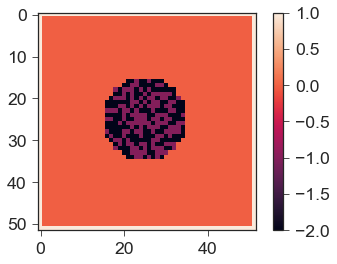

In [93]:
plt.imshow(bc_map)
plt.colorbar()

In [60]:
# Initialize rho...one everywhere, except in the circle where cells were inoculated

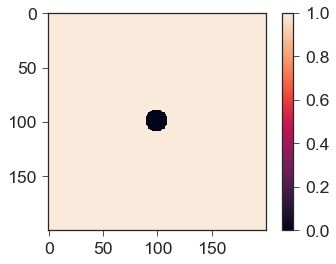

In [61]:
rho = np.ones((nx, ny), dtype=lb.num_type)
bc_in_domain = bc_map[halo:-halo, halo:-halo]

rho[bc_in_domain < 0] = 0

plt.imshow(rho)
plt.colorbar()

In [62]:
m0 = .1

14.630367358614947


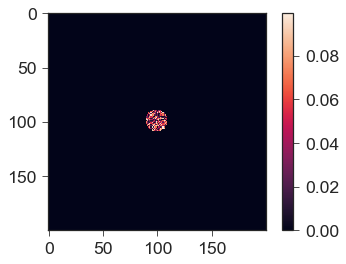

In [63]:
# Initialize the current amount of absorbed mass randomly

absorbed_mass = m0*np.random.rand(nx, ny)
bc_in_domain = bc_map[halo:-halo, halo:-halo]

absorbed_mass[bc_in_domain >= 0] = 0

plt.imshow(absorbed_mass)
plt.colorbar()

print absorbed_mass.sum()

In [64]:
#k0 = .5 For Da = 600
k0 = 0.001
k_list = [k0, k0]

m_reproduce_list = [m0, .925*m0]
velocity_set = 'D2Q9'
D = .5 * (1./3.)

Da = nx * k_list[0]/D
print Da

1.2


In [65]:
dla_colony = lb.DLA_Colony(
    ctx_info=ctx_info, velocity_set='D2Q9',
    bc_map=bc_map, 
    D=D, k_list=k_list, m_reproduce_list=m_reproduce_list,
    absorbed_mass=absorbed_mass, rho=rho)

global size: (224, 208)
local size: (32, 16)
The platforms detected are:
---------------------------
NVIDIA CUDA NVIDIA Corporation version: OpenCL 1.2 CUDA 9.0.282
The devices detected on platform NVIDIA CUDA are:
---------------------------
GeForce GTX TITAN Black [Type: GPU ]
Maximum clock Frequency: 980 MHz
Maximum allocable memory size: 1594 MB
Maximum work group size 1024
Maximum work item dimensions 3
Maximum work item size [1024L, 1024L, 64L]
---------------------------
This context is associated with  1 devices
tau 0.9999999999999998
omega 1.0000000000000002
global_size_bc: (224, 208)
Connecting python to the opencl_kernel init_feq...
Connecting python to the opencl_kernel collide_and_propagate...
Creating local memory of double type...
Creating local memory of int type...
Connecting python to the opencl_kernel update_after_streaming...
Connecting python to the opencl_kernel reproduce...
Creating local memory of int type...
Connecting python to the opencl_kernel copy_streamed_

In [74]:
dla_colony.run(1000)
#dla_colony.collide_and_propagate.run().wait()

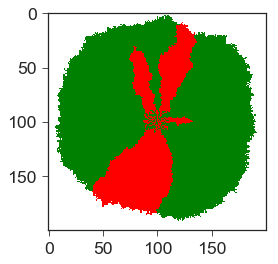

In [76]:
from matplotlib import colors

cmap = colors.ListedColormap(['white','red', 'green'])

pops = dla_colony.get_pop_field()
plt.imshow(pops, cmap=cmap)
plt.savefig('selective_advantage.png', dpi=300, bbox_inches='tight')

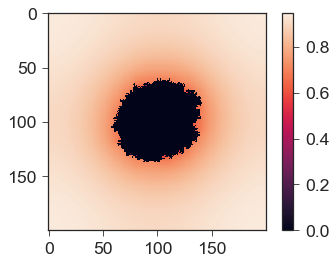

In [28]:
plt.imshow(dla_colony.rho.get())
plt.colorbar()

I don't understand why the density isn't zero inside the population. That is very weird...what's going on? lol.